## Bird Song Classification Data Processing
#### Author: Santiago Miro 2024

This notebook will perform all the necessary EDA, pre-processing and processing of the data set "Bird Song Data Set" obtained from https://www.kaggle.com/datasets/vinayshanbhag/bird-song-data-set.

A small collection of bird songs from 5 species, to explore classification / identification of a bird in this set with an audio recording. Original source is https://www.xeno-canto.org/

Content:

Data set includes only "songs" from 5 species:


* Bewick's Wren
* Northern Cardinal
* American Robin
* Song Sparrow
* Northern Mockingbird

For simplicity, data set excludes other types of calls (alarm calls, scolding calls etc) made by these birds. Additionally, only recordings graded as highest quality on xeno-canto API are included.

Original recordings from xeno-canto were in mp3. All files were converted to wav format. Further, using onset detection, original recordings of varying lengths were clipped to exactly 3sec such that some portion of the target bird's song is included in the clip.
Original mp3 files from the source have varying sampling rates and channels. As part of the conversion process each wav file was sampled at exactly 22050 samples/sec and is single channel.

CSV file includes recording metadata, such as genera, species, location, datetime, source url, recordist and license information.
The filename column in CSV corresponds to the wav files under wavfiles folder.

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from IPython.display import Audio
import librosa
import numpy as np
from tqdm import tqdm
import pickle as pkl

In [4]:
#Import bird song metadata with pandas
bird_df = pd.read_csv('path/to/metadata/bird_songs_metadata.csv')
bird_df.head()


,id,genus,species,subspecies,name,recordist,country,location,latitude,longitude,altitude,sound_type,source_url,license,time,date,remarks,filename
0,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-0.wav
1,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-1.wav
2,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-4.wav
3,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-5.wav
4,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-6.wav


In [5]:
#Get the shape
bird_df.shape

(5422, 18)

In [6]:
#Check column types
bird_df.dtypes

id              int64
genus          object
species        object
subspecies     object
name           object
recordist      object
country        object
location       object
latitude      float64
longitude     float64
altitude       object
sound_type     object
source_url     object
license        object
time           object
date           object
remarks        object
filename       object
dtype: object

In [7]:
#Check if filename and id name do not match
bird_unmatch = bird_df[bird_df['filename'].apply(lambda x: x[:6]) == bird_df['id'].astype(str)]
merged = pd.merge(bird_df, bird_unmatch, how='outer', indicator=True)

# Filter out the rows present in the second dataset
rows_not_in_second = merged[merged['_merge'] == 'left_only']

In [8]:
#Check shape
bird_df.shape

(5422, 18)

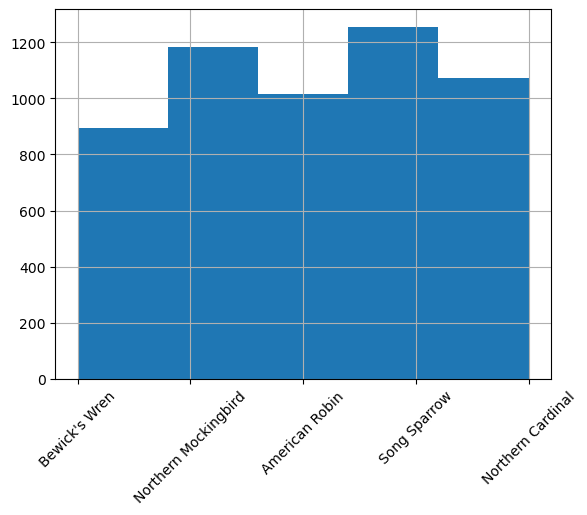

In [9]:
#Histogram of bird type names from metadata
bird_df['name'].hist(bins=5)
plt.xticks(rotation=45)
plt.show()


In [10]:
#Only save the state from the registrated item if known
bird_df['location'] = bird_df['location'].apply(lambda x: x.split(',')[-1].strip())


In [11]:
#Clean abreviations and input errors

bird_df['location'] = bird_df['location'].apply(lambda x: 'California' if x == 'CA' else x)
bird_df['location'] = bird_df['location'].apply(lambda x: 'Louisiana' if x == 'LA' else x)
bird_df['location'] = bird_df['location'].apply(lambda x: 'Washington' if x == 'WA' else x)
bird_df['location'] = bird_df['location'].apply(lambda x: 'Maine' if x == 'ME' else x)
bird_df['location'] = bird_df['location'].apply(lambda x: 'Michigan' if x == 'Lake Erie Metropark' else x)
bird_df['location'] = bird_df['location'].apply(lambda x: 'California' if x == 'Cerro Alto Campground' else x)
bird_df['location'] = bird_df['location'].apply(lambda x: 'California' if x == 'Inyo County' else x)
bird_df['location'] = bird_df['location'].apply(lambda x: 'California' if x == 'San Diego County' else x)
bird_df['location'] = bird_df['location'].apply(lambda x: 'Arizona' if x == 'AZ' else x)
bird_df['location'] = bird_df['location'].apply(lambda x: 'Colorado' if x == 'CO' else x)
bird_df['location'] = bird_df['location'].apply(lambda x: 'Arizona' if x == 'AZ' else x)
bird_df['location'] = bird_df['location'].apply(lambda x: 'Connecticut' if x == 'CT' else x)
bird_df['location'] = bird_df['location'].apply(lambda x: 'Georgia' if x == 'GA USA' else x)
bird_df['location'] = bird_df['location'].apply(lambda x: 'Michigan' if x == 'MI' else x)
bird_df['location'] = bird_df['location'].apply(lambda x: 'New York' if x == 'New York City' else x)
bird_df['location'] = bird_df['location'].apply(lambda x: 'Oklahoma' if x == 'OK' else x)
bird_df['location'] = bird_df['location'].apply(lambda x: 'Pennsylvania' if x == 'PA' else x)
bird_df['location'] = bird_df['location'].apply(lambda x: 'Texas' if x == 'TX' else x)
bird_df['location'] = bird_df['location'].apply(lambda x: 'Kentucky' if x == 'Hisle Park' else x)
bird_df['location'] = bird_df['location'].apply(lambda x: 'New Mexico' if x == 'Ute Lake State Park' else x)
bird_df['location'] = bird_df['location'].apply(lambda x: 'Ohio' if x == 'Battelle Darby Metro Park--Darby Dan Training Loop trail (SW corner)' else x)
bird_df['location'] = bird_df['location'].apply(lambda x: 'Not Determined' if x == 'backyard' else x)
bird_df['location'] = bird_df['location'].apply(lambda x: 'Not Determined' if x == 'USA' else x)















In [14]:
#Check for inconsistencies
bird_df['location'].unique()

array(['Washington', 'Arizona', 'California', 'Nevada', 'Colorado',
       'New Mexico', 'Wyoming', 'Texas', 'Missouri', 'Pennsylvania',
       'Tennessee', 'Louisiana', 'Massachusetts', 'Not Determined',
       'Florida', 'New Jersey', 'North Carolina', 'Virginia', 'Georgia',
       'Montana', 'New York', 'Alaska', 'Kentucky', 'Connecticut',
       'Michigan', 'District of Columbia', 'Illinois', 'Mississippi',
       'Minnesota', 'Vermont', 'Iowa', 'Utah', 'New Hampshire', 'Maine',
       'Oregon', 'Delaware', 'Ohio', 'Alabama', 'South Carolina',
       'Kansas', 'Oklahoma', 'Hawaii', 'Wisconsin'], dtype=object)

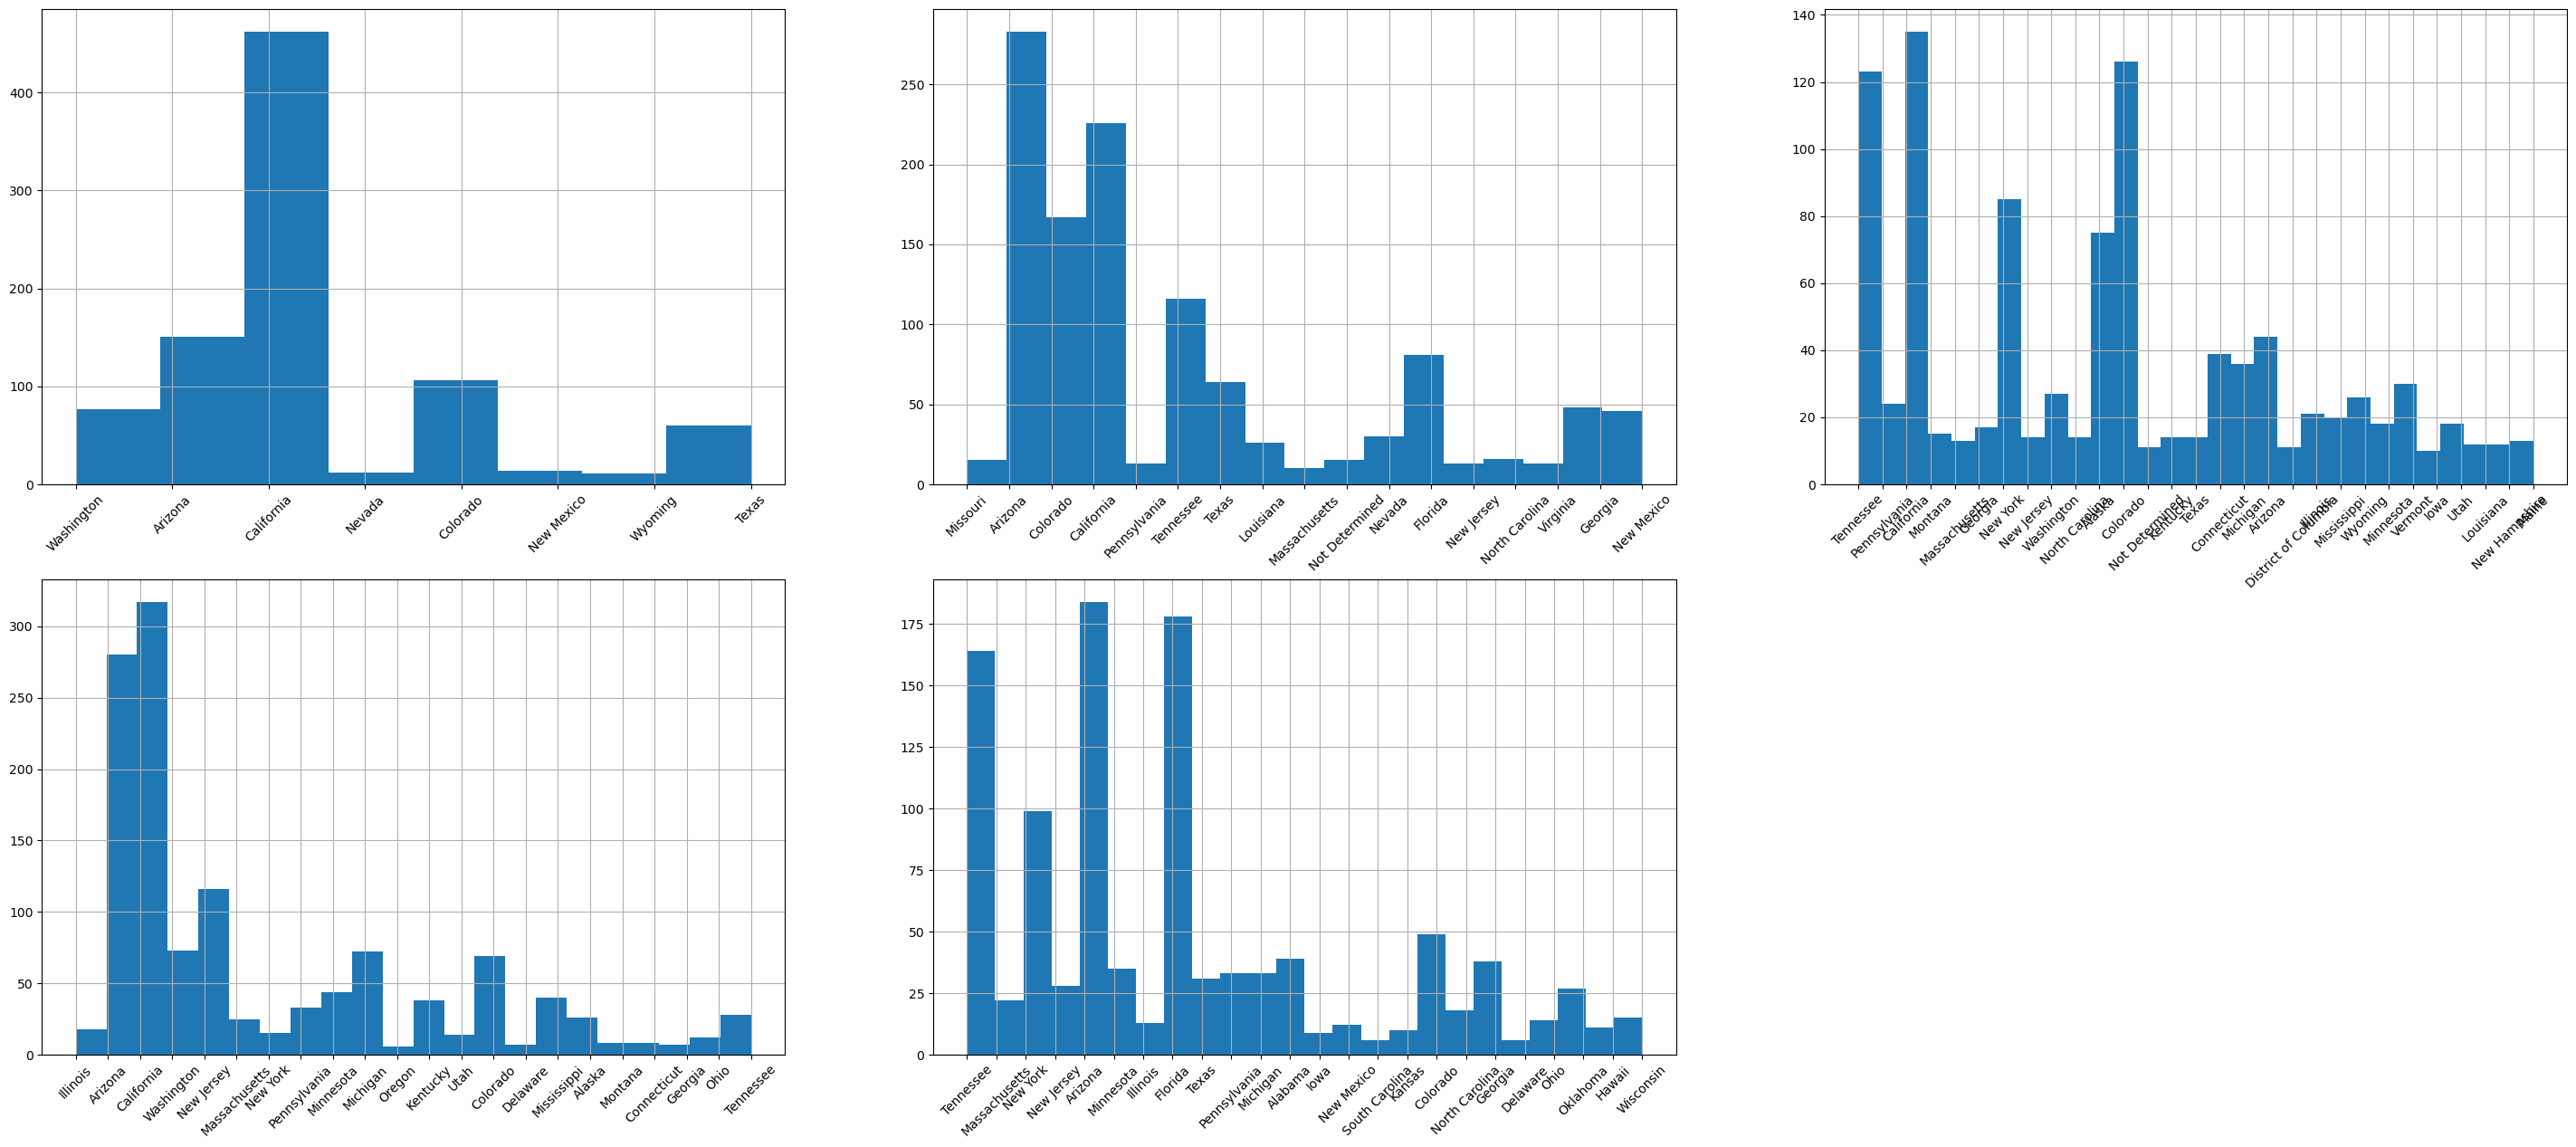

In [27]:
#Histogram of bird names by location
plt.figure(figsize = (36,15))
plt.subplot(231)
bird_df[bird_df['name'] == 'Bewick\'s Wren']['location'].hist(bins=8)
plt.xticks(rotation=45)

plt.subplot(232)
bird_df[bird_df['name'] == 'Northern Mockingbird']['location'].hist(bins=17)
plt.xticks(rotation=45)

plt.subplot(233)
bird_df[bird_df['name'] == 'American Robin']['location'].hist(bins=29)
plt.xticks(rotation=45)

plt.subplot(234)
bird_df[bird_df['name'] == 'Song Sparrow']['location'].hist(bins=22)
plt.xticks(rotation=45)

plt.subplot(235)
bird_df[bird_df['name'] == 'Northern Cardinal']['location'].hist(bins=24)
plt.xticks(rotation=45)

plt.show()


In [28]:
#Check inconsistencies in sound type.
#Decided to leave as is for the time being.

bird_df['sound_type'].unique()


array(['adult, sex uncertain, song', 'song', 'call, song', 'Song',
       'Song, various calls',
       'adult, mimicry/imitation, sex uncertain, song', 'adult, song',
       'mimicry/imitation, song',
       'life stage uncertain, sex uncertain, song', 'call, mimicry, song',
       'Mimic, song',
       'Carolina Wren and Eastern Kingbird, mimicry of Blue Jay, song',
       'adult, male, song', 'male, song', 'vesper song',
       'alarm call, song', 'plastic song, song', 'dawn song',
       'call, whisper song', 'calling whilst foraging, song', 'subsong',
       'juvenile, subsong', 'song, call, chase, interaction ticks',
       'interaction tick series, song,call',
       'life stage uncertain, male, song',
       'adult, call, sex uncertain, song', 'call, male, song',
       'Several different song types appear in this recording of part of a single bout.,',
       'call, female, song', 'male-female duet, song', 'female song'],
      dtype=object)

In [29]:
#Path to bird songs dataset
path = 'path\to\\wavfiles\\'

In [30]:
#Get labels of those registered in metadata and files.
files = os.listdir(path)
filename_labels=[]
for element in files:
    matching_row = bird_df[bird_df['filename'] == element]
    if not matching_row.empty:
        filename_labels.append(matching_row['filename'].iloc[0])


In [31]:
#Noticed more elements in files than in metadata.
#For training purposes, we only keep files with known metadata.
items_not_in_second = [item for item in files if item not in filename_labels]
items_not_in_second = [item[:6] for item in items_not_in_second]

In [34]:
#Confirm the df is clean
for item in items_not_in_second:
    matching_row = bird_df[bird_df['id'].astype(str) == item]
    if not matching_row.empty:
        print(matching_row)

In [38]:
#Get audio files that match the Id in labels
audio_files = [item for item in files if item in filename_labels]

In [39]:
name_labels=[]
for element in audio_files:
    matching_row = bird_df[bird_df['filename'] == element]
    if not matching_row.empty:
        name_labels.append(matching_row['name'].iloc[0])

(array([1256.,    0., 1017.,    0.,    0.,  893.,    0., 1074.,    0.,
        1182.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

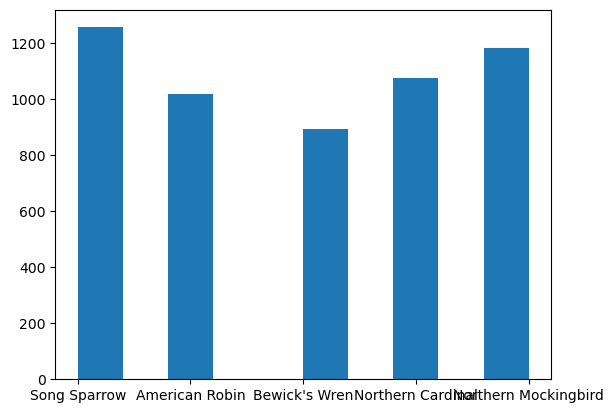

In [40]:
plt.hist(name_labels)

In [41]:
# Load and play the audio file
Audio(path + '546760-4.wav',autoplay=True)

In [42]:
# Data Processing

#Extract MFCCS (Mel-Frequency Cepstral Coefficients) from radio file.
def extract_mfcc(audio_file, num_mfcc=13):
    y, sr = librosa.load(audio_file, sr=None)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=num_mfcc)
    return mfccs

#Alternatively extract spectograms from audio file.
def extract_spectrogram(audio_file):
    y, sr = librosa.load(audio_file, sr=None)
    spectrogram = np.abs(librosa.stft(y))
    return spectrogram


#Normalize feautres extraced
def normalize_features(features):
    # Perform feature-wise normalization
    normalized_features = (features - np.mean(features, axis=0)) / np.std(features, axis=0)
    return normalized_features


def prepare_dataset(audio_files, labels):
    X = []
    y = []
    for audio_file, label in tqdm(zip(audio_files, labels)):
        mfccs = extract_mfcc(audio_file)
        # Normalize features
        mfccs_normalized = normalize_features(mfccs)
        X.append(mfccs_normalized)
        y.append(label)
    return np.array(X), np.array(y)

def prepare_spectrogram(audio_files, labels):
    X = []
    y = []
    for audio_file, label in tqdm(zip(audio_files, labels)):
        spectrogram = extract_spectrogram(audio_file)
        X.append(spectrogram)
        y.append(label)
    return np.array(X), np.array(y)



In [43]:
audio_files = [path + item for item in audio_files]

In [51]:
X, y = prepare_dataset(audio_files,name_labels)

5422it [02:11, 41.10it/s]


In [52]:
f = open('processed_data.pkl','wb')
pkl.dump(X,f)
f.close()

In [53]:
f = open('processed_labels.pkl','wb')
pkl.dump(y,f)
f.close()

In [25]:
X_spec, y_spec = prepare_spectrogram(audio_files,name_labels)

5422it [01:40, 53.86it/s]


In [27]:
f = open('processed_spec.pkl','wb')
pkl.dump(X_spec,f)
f.close()

f = open('processed_labels.pkl','wb')
pkl.dump(y_spec,f)
f.close()